In [12]:
import torch
import torch.nn as nn
import numpy as np



Shape: torch.Size([100, 6])
First 5 rows:
 tensor([[1902.0000, 1156.0000, 2221.1001, 2076.0000, 3193.0000, 1304.0000],
        [2148.0000, 1264.0000, 2291.5000,  804.0000, 3024.0000, 1557.8076],
        [2070.0000, 1477.0127, 2188.8000,  902.0000, 3068.0000, 1464.8076],
        [1906.0000, 1564.0000, 2197.8000,  995.0000, 3224.0000, 1396.0000],
        [1871.0000, 1521.0127, 1950.3000,  805.0000, 3215.0000, 1072.1924]])


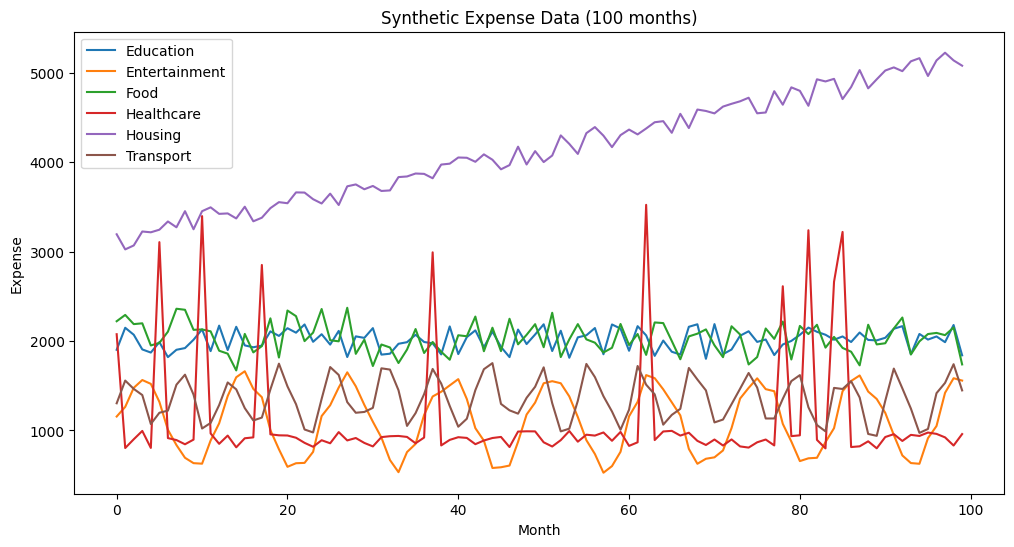

In [13]:
import numpy as np
import torch
import matplotlib.pyplot as plt

np.random.seed(42)

months = np.arange(100)  # 100 months

# 1. Education (stable with small random fluctuations)
education = 2000 + np.random.randint(-200, 200, size=100)

# 2. Entertainment (seasonal, spikes every 12 months like holidays)
entertainment = 1000 + 500*np.sin(2*np.pi*months/12) + np.random.randint(0, 200, size=100)

# 3. Food (correlated with travel + some noise)
travel = np.random.randint(500, 2000, size=100)
food = 1500 + 0.3*travel + np.random.randint(0, 300, size=100)

# 4. Healthcare (occasional spikes, otherwise low)
healthcare = 800 + np.random.randint(0, 200, size=100)
healthcare[np.random.choice(100, 10, replace=False)] += np.random.randint(1000, 3000, size=10)

# 5. Housing (steady upward trend, inflation-like)
housing = 3000 + months*20 + np.random.randint(0, 300, size=100)

# 6. Transport (random-ish, but mildly seasonal)
transport = 1200 + 300*np.sin(2*np.pi*months/6) + np.random.randint(0, 300, size=100)

# Stack all categories
data = np.stack([education, entertainment, food, healthcare, housing, transport], axis=1).astype(np.float32)
data = torch.tensor(data)

print("Shape:", data.shape)
print("First 5 rows:\n", data[:5])

# Plot to visualize patterns
categories = ["Education", "Entertainment", "Food", "Healthcare", "Housing", "Transport"]
plt.figure(figsize=(12, 6))
for i in range(6):
    plt.plot(months, data[:, i], label=categories[i])
plt.legend()
plt.title("Synthetic Expense Data (100 months)")
plt.xlabel("Month")
plt.ylabel("Expense")
plt.show()


In [14]:
# Normalize data (important for NN training)
data = (data - data.mean(axis=0)) / data.std(axis=0)
#data.std(axis=0) computes the standard deviation of each column (feature) in the data NumPy array

# Prepare sequences (last 3 months -> predict next month) if less than 3 months take len(data)-1
seq_length = min(3, len(data)-1)

X, y = [], []
for i in range(len(data) - seq_length):
    X.append(data[i:i+seq_length])   # past 3 months
    y.append(data[i+seq_length])     # next month

X = np.array(X)  # shape: (samples, seq_len, features)
y = np.array(y)  # shape: (samples, features)

# Convert to tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

In [15]:
X,y

(tensor([[[-0.9671,  0.1364,  1.1314,  1.5166, -1.5845, -0.2043],
          [ 1.2011,  0.4422,  1.5523, -0.4746, -1.8669,  0.9062],
          [ 0.5137,  1.0454,  0.9382, -0.3212, -1.7934,  0.4993]],
 
         [[ 1.2011,  0.4422,  1.5523, -0.4746, -1.8669,  0.9062],
          [ 0.5137,  1.0454,  0.9382, -0.3212, -1.7934,  0.4993],
          [-0.9318,  1.2918,  0.9921, -0.1756, -1.5328,  0.1983]],
 
         [[ 0.5137,  1.0454,  0.9382, -0.3212, -1.7934,  0.4993],
          [-0.9318,  1.2918,  0.9921, -0.1756, -1.5328,  0.1983],
          [-1.2403,  1.1700, -0.4877, -0.4731, -1.5478, -1.2185]],
 
         ...,
 
         [[ 0.5930, -1.3588, -0.2150, -0.2633,  1.7032, -1.6517],
          [ 0.0377, -0.5489,  0.2758, -0.2038,  1.3707, -1.4591],
          [ 0.3462, -0.1638,  0.3505, -0.2273,  1.6614,  0.2901]],
 
         [[ 0.0377, -0.5489,  0.2758, -0.2038,  1.3707, -1.4591],
          [ 0.3462, -0.1638,  0.3505, -0.2273,  1.6614,  0.2901],
          [-0.2179,  0.8868,  0.2023, -0.2884,  

In [16]:
# Define LSTM model
class ExpensePredictor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ExpensePredictor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]   # take last time step
        out = self.fc(out)
        return out


In [17]:
# Model params
input_size = 6      # categories: Education, Entertainment, Food, Healthcare, Housing, Transport
hidden_size = 16
output_size = 6     # predict all 6 categories

expense_predictor_model = ExpensePredictor(input_size, hidden_size, output_size)

In [18]:
# Loss & optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(expense_predictor_model.parameters(), lr=0.01)


MSELoss → minimizes squared error between predicted and actual expenses.

Adam optimizer → updates weights.

We train for 200 epochs.

Every iteration, the model learns to map “past 3 months → next month”.

In [19]:
# Training loop
epochs = 200
for epoch in range(epochs):
    expense_predictor_model.train()
    output = expense_predictor_model(X)
    loss = criterion(output, y)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

Epoch [50/200], Loss: 0.3860
Epoch [100/200], Loss: 0.1052
Epoch [150/200], Loss: 0.0155
Epoch [200/200], Loss: 0.0042


In [20]:
with torch.no_grad():
    last_seq = torch.tensor(data[-3:], dtype=torch.float32).unsqueeze(0)  # shape (1, seq_len, features)
    prediction = expense_predictor_model(last_seq)
    print("Next month prediction (normalized):", prediction.numpy())

Next month prediction (normalized): [[ 2.154457    0.5472779   0.37993    -1.0760461   1.3380135  -0.31358558]]


C:\Users\jayas\AppData\Local\Temp\ipykernel_18296\1001569553.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  last_seq = torch.tensor(data[-3:], dtype=torch.float32).unsqueeze(0)  # shape (1, seq_len, features)


In [ ]:
# Denormalize prediction
mean = np.mean(data, axis=0)  # mean for each feature
std = np.std(data, axis=0)    # standard deviation for each feature

real_prediction = prediction.numpy() * std + mean
print("Predicted expenses (Food, Travel, Entertainment, Utilities):")
print(real_prediction)


Predicted expenses (Food, Travel, Entertainment, Utilities):
[[5323.16856384 2209.45558548 1137.99299896 1513.91631126 1266.90067649
   890.59243262]]


In [23]:
#saving model
torch.save(expense_predictor_model.state_dict(), 'expense_predictor_model.pth')